# Prelim Skills Exam
Submitted by: Emmanuel Q. Abo

Submitted to: Engr. Roman Richard

In [1]:
import numpy as np 
import pandas as pd 
import os
import glob

%matplotlib inline
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
xray_df = pd.read_csv('archive/Data_Entry_2017.csv')
drop_cols = ['Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position',
            'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]']

# Drop the specified columns
xray_df.drop(columns=drop_cols, inplace=True)


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
image_paths = {os.path.basename(x): x for x in 
               glob.glob(os.path.join('archive', 'images*', '*', '*.png'))}

In [5]:
print('Total images scanned:', len(image_paths))
print('Total index', xray_df.shape[0])

Total images scanned: 112120
Total index 112120


In [6]:
print('Images found:', len(image_paths), ', Total Index', xray_df.shape[0])
xray_df['path'] = xray_df['Image Index'].map(image_paths.get)
xray_df.sample(5)

Images found: 112120 , Total Index 112120


,Image Index,Finding Labels,Unnamed: 11,path
31891,00008342_004.png,Pneumothorax,NaN,archive\images_004\images\00008342_004.png
112031,00030744_000.png,Infiltration,NaN,archive\images_012\images\00030744_000.png
82999,00020405_017.png,Nodule,NaN,archive\images_009\images\00020405_017.png
17488,00004714_001.png,Nodule,NaN,archive\images_003\images\00004714_001.png
81896,00020147_012.png,Effusion|Nodule,NaN,archive\images_009\images\00020147_012.png


In [7]:

from itertools import chain
labels = np.unique(list(chain(*xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x)>0]
print('All Labels ({}): {}'.format(len(labels), labels))
for c_label in labels: # one-hot encoding
    if len(c_label)>1: # leave out empty labels
        xray_df[c_label] = xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
62579,00015497_000.png,Cardiomegaly|Effusion,NaN,archive\images_007\images\00015497_000.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95108,00024825_000.png,No Finding,NaN,archive\images_011\images\00024825_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
104041,00027761_000.png,Consolidation|Mass|Nodule,NaN,archive\images_011\images\00027761_000.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


# Prepare Train Data

In [8]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(xray_df, 
                                   test_size = 0.25, 
                                   random_state = 28,
                                   stratify = xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', test_df.shape[0])

train 84090 validation 28030


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size = (224, 224)
core_idg = ImageDataGenerator(samplewise_center=True, 
                                  samplewise_std_normalization=True, 
                                  horizontal_flip = True, 
                                  vertical_flip = False, 
                                  height_shift_range= 0.05, 
                                  width_shift_range=0.1, 
                                  rotation_range=5, 
                                  shear_range = 0.1,
                                  fill_mode = 'reflect',
                                  zoom_range=0.15)

In [10]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [11]:
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [12]:
train_df.sample(5)

,Image Index,Finding Labels,Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,newLabel
22605,00005986_012.png,Emphysema|Pneumothorax,NaN,archive\images_003\images\00005986_012.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Emphysema, Pneumothorax]"
94385,00024164_002.png,No Finding,NaN,archive\images_010\images\00024164_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]
107849,00029159_004.png,No Finding,NaN,archive\images_012\images\00029159_004.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]
59701,00014732_006.png,Atelectasis|Infiltration,NaN,archive\images_007\images\00014732_006.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[Atelectasis, Infiltration]"
33427,00008758_000.png,No Finding,NaN,archive\images_004\images\00008758_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,[No Finding]


In [13]:
train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
directory=None,
x_col = 'path',
y_col = 'newLabel',
class_mode = 'categorical',
classes = labels,
target_size = img_size,
color_mode = 'rgb',
batch_size = 32)

valid_gen = core_idg.flow_from_dataframe(dataframe=test_df,
directory=None,
x_col = 'path',
y_col = 'newLabel',
class_mode = 'categorical',
classes = labels,
target_size = img_size,
color_mode = 'rgb',
batch_size = 256) 

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=test_df,
directory=None,
x_col = 'path',
y_col = 'newLabel',
class_mode = 'categorical',
classes = labels,
target_size = img_size,
color_mode = 'rgb',
batch_size = 1024))

Found 84090 validated image filenames belonging to 15 classes.
Found 28030 validated image filenames belonging to 15 classes.
Found 28030 validated image filenames belonging to 15 classes.


In [14]:
X_train, y_train = next(train_gen)

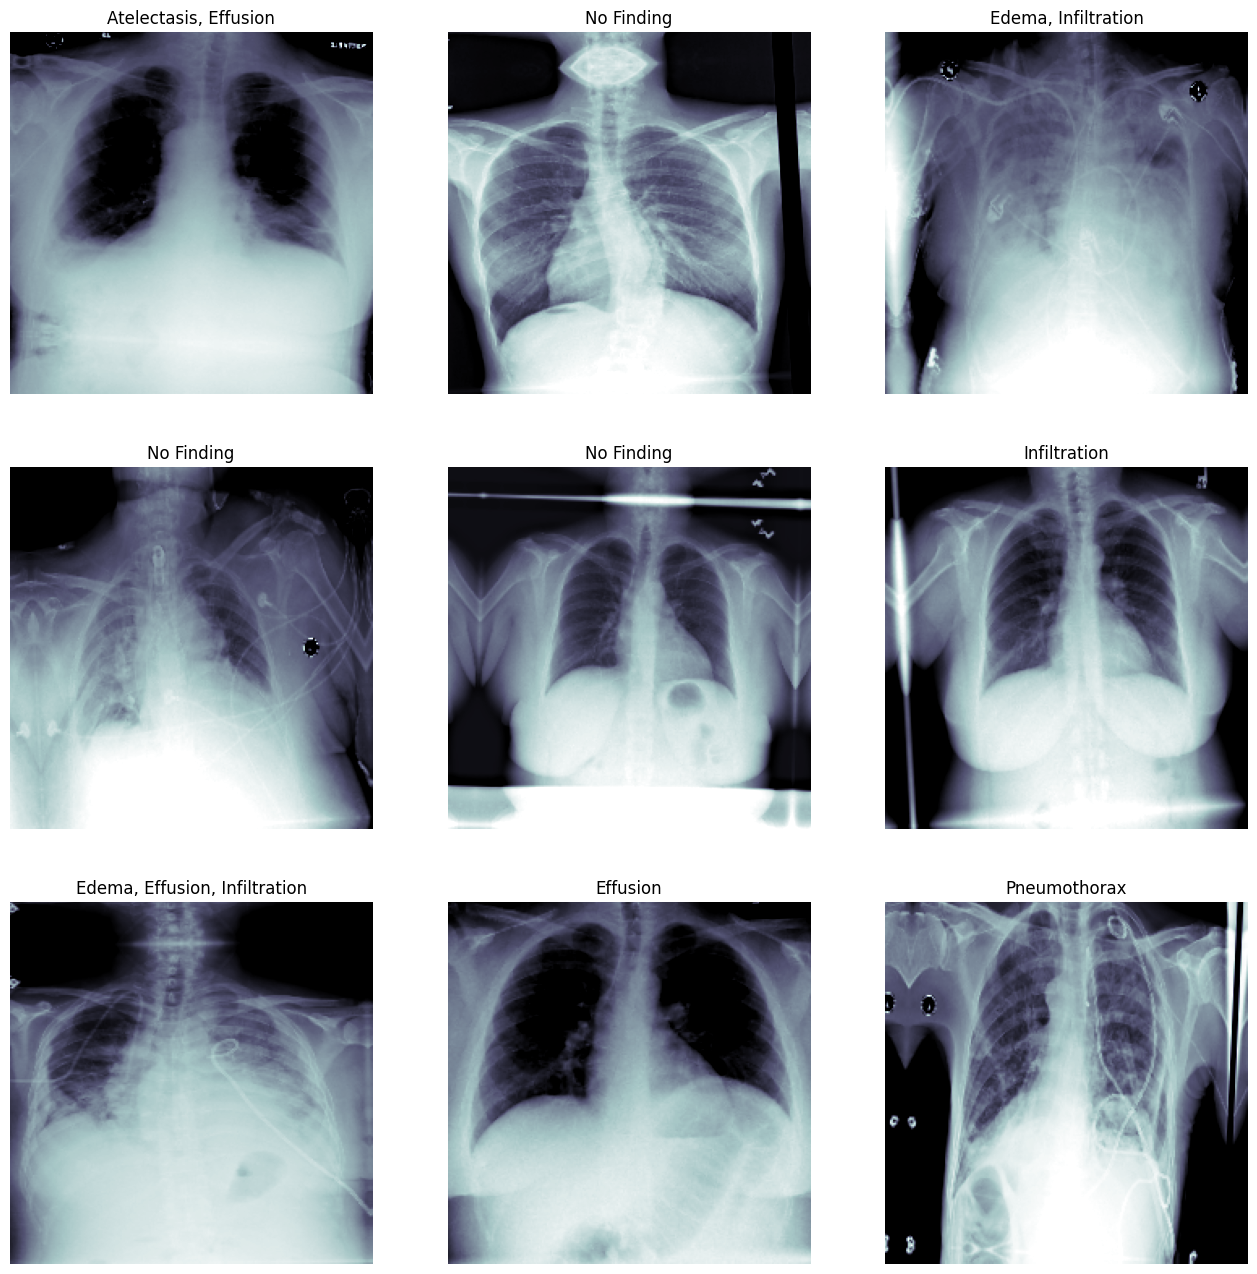

In [15]:
fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(X_train, y_train, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# MODEL FROM SCRATCH

Create the model

In [16]:
from keras.models import Sequential
from keras.layers import MaxPooling2D, Dense, Dropout, Flatten, Conv2D, Activation, BatchNormalization
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

In [17]:
model_1 = Sequential()

# Convolutional layers
model_1.add(Conv2D(32, (2, 2), strides=(1, 1), input_shape=X_train.shape[1:], activation='relu'))
model_1.add(Conv2D(32, (2, 2), strides=(1, 1), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(64, (2, 2), strides=(1, 1), activation='relu'))
model_1.add(Conv2D(64, (2, 2), strides=(1, 1), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(128, (2, 2), strides=(1, 1), activation='relu'))
model_1.add(Conv2D(128, (2, 2), strides=(1, 1), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(256, (2, 2), strides=(1, 1), activation='relu'))
model_1.add(Conv2D(256, (2, 2), strides=(1, 1), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# flatten layers
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.25))

# output layer
model_1.add(Dense(len(labels), activation = 'sigmoid'))

model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 223, 223, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 110, 110, 64)   │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 53, 53, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 25, 25, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,242,191 (20.00 MB)

 Trainable params: 5,242,191 (20.00 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model_1.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['binary_accuracy'])
hist_1 = model_1.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=5,
    verbose=1,
    validation_data=(test_X, test_Y))

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - binary_accuracy: 0.8843 - loss: 0.3103 - val_binary_accuracy: 0.9216 - val_loss: 0.2313
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - binary_accuracy: 0.9168 - loss: 0.2369 - val_binary_accuracy: 0.9216 - val_loss: 0.2174
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - binary_accuracy: 0.9158 - loss: 0.2409 - val_binary_accuracy: 0.9255 - val_loss: 0.2186
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - binary_accuracy: 0.9177 - loss: 0.2336 - val_binary_accuracy: 0.9249 - val_loss: 0.2119
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - binary_accuracy: 0.9264 - loss: 0.2142 - val_binary_accuracy: 0.9268 - val_loss: 0.2133


In [19]:
pred_Y = model_1.predict(test_X, batch_size = 32, verbose = True)


32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step


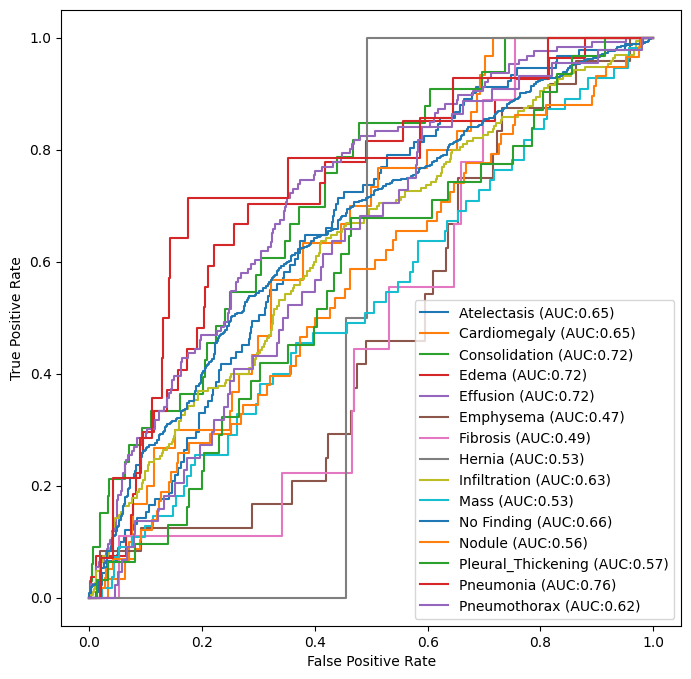

In [20]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

<Figure size 1200x600 with 0 Axes>

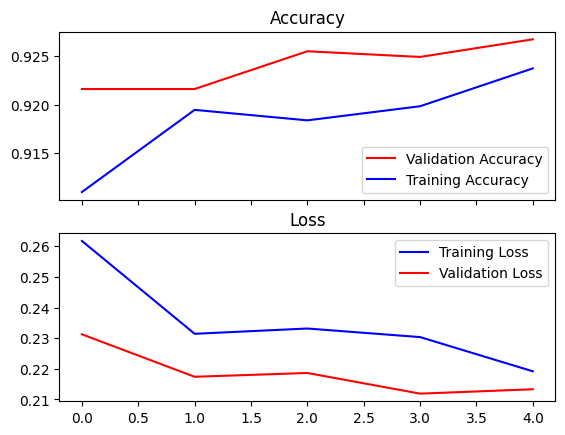

In [21]:
plt.figure(figsize=(12, 6))

fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(hist_1.history["val_binary_accuracy"],'r', label="Validation Accuracy")
ax[0].plot(hist_1.history["binary_accuracy"],'b', label="Training Accuracy")
ax[0].set_title("Accuracy")

ax[1].plot(hist_1.history["loss"],'b', label="Training Loss")
ax[1].plot(hist_1.history["val_loss"],'r', label="Validation Loss")
ax[1].set_title("Loss")

ax[0].legend()
ax[1].legend()

# PRE-TRAINED MODEL

In [22]:
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D, Input
from keras.models import Model
# Load pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Modify
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(labels), activation='sigmoid')(x)

# Final Model
pre_trained_model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [24]:
pre_trained_model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849,871 (56.65 MB)

 Trainable params: 135,183 (528.06 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
pre_trained_model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['binary_accuracy'])
pre_trained_hist_1 = pre_trained_model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=5,
    verbose=1,
    validation_data=(test_X, test_Y))

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 332s 7s/step - binary_accuracy: 0.8422 - loss: 0.3702 - val_binary_accuracy: 0.9270 - val_loss: 0.2167
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 345s 7s/step - binary_accuracy: 0.9226 - loss: 0.2212 - val_binary_accuracy: 0.9216 - val_loss: 0.2167
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - binary_accuracy: 0.9265 - loss: 0.2125 - val_binary_accuracy: 0.9259 - val_loss: 0.2107
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 341s 7s/step - binary_accuracy: 0.9245 - loss: 0.2153 - val_binary_accuracy: 0.9259 - val_loss: 0.2093
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 332s 7s/step - binary_accuracy: 0.9306 - loss: 0.2007 - val_binary_accuracy: 0.9304 - val_loss: 0.2064


In [26]:
pred_Y = pre_trained_model.predict(test_X, batch_size = 32, verbose = True)

32/32 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step


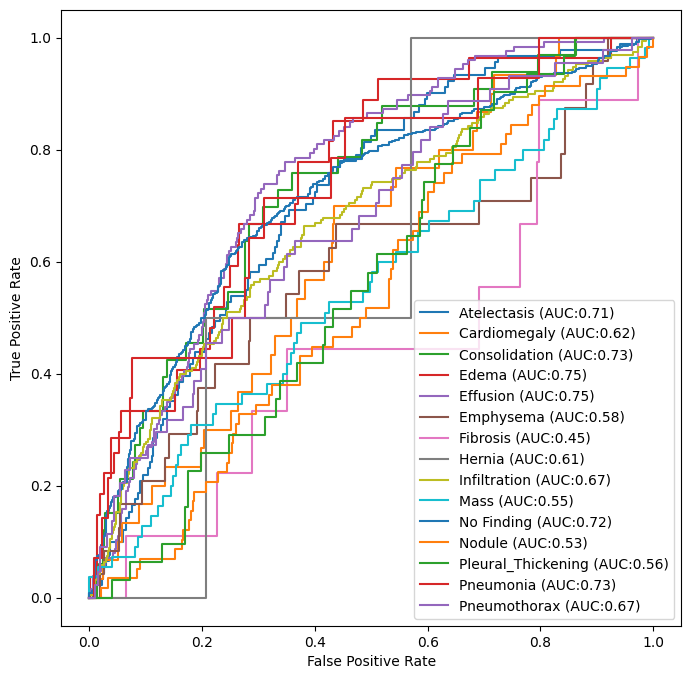

In [27]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

<Figure size 1200x600 with 0 Axes>

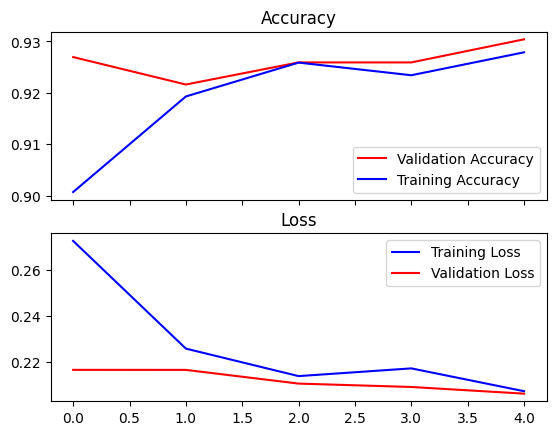

In [28]:
plt.figure(figsize=(12, 6))

fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(pre_trained_hist_1.history["val_binary_accuracy"],'r', label="Validation Accuracy")
ax[0].plot(pre_trained_hist_1.history["binary_accuracy"],'b', label="Training Accuracy")
ax[0].set_title("Accuracy")

ax[1].plot(pre_trained_hist_1.history["loss"],'b', label="Training Loss")
ax[1].plot(pre_trained_hist_1.history["val_loss"],'r', label="Validation Loss")
ax[1].set_title("Loss")

ax[0].legend()
ax[1].legend()

# Conclusion
The exam was very challenging, mainly because of the large amount of data in dataset given. I faced many obstacles while progressing through the activity, obstacles such as kernels dying, lengthy training, and my computer crashing due to the high amount of computational resources required to handle the processing. In addition, optimizing and tuning model architecture proved to be the most time-consuming while I was doing the activity. The slow process and numerous training iterations needed to see if the model is improving limited me to settling for a low epoch because my computer kept crashing. Despite the numerous challenges I encountered I still learned and gained a deeper understanding of convolutional neural network architectures, utilizing pre-trained models, and the concept of fine-tuning pre-trained models which can have a significant impact on the performance of the model. 